%
\section{Classification Dataset: Kaggle Congressional Voting (\href{https://www.kaggle.com/c/184702-tu-ml-ss-21-congressional-voting/overview}{link to dataset})}

The Congressional Voting dataset is used for classification, it is a prediction on the party (republican or democrat) for politicians of the congress. It consists of 218 samples and 17 attributes where 15 attributes are given as string values (but corresponding to booleans) and 1 further as numerical value, the id of the row, which is not relevant so we drop it during the preprocessing step. This dataset is quite small but with quite big dimension. 
The label is an ordinal value, "democrat" or "republican", and during the preprocessing step we transform it to respectively 0 and 1 value, and we replace "y" and "n" by 1 and 0. Hence, we have now only binary values. The description of the training dataset is the following {insert figure}.

We can see that there are some missing values, and we have the repartition of missing values among samples with the following table {insert table}. We can notice that the feature "export-administration-act-south-africa" is the most incomplete one, with 23% missing values, the other features having less than 11% missing values.
The threshold for the minimum number of known values to conserve a row will be a tuning parameter for the algorithms.
We also tried to impute them with a multivariate feature imputation or a KNN imputer, but the results were better with the random method (at least 15% of decrease in accuracy for each algorithm).

We have to notice about this dataset that the false negatives and false positives show no theoritical difference: we do not have to privilege one over the other. So the performance by class should be barely the same. What is more, we can see that the training dataset is inbalanced, so we will use balanced indicators (such as balanced accuracy and f1 score), and make sure that our precision and recall are close.

In [1]:
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

training = pd.read_csv("./CongressionalVotingID.shuf.lrn.csv")
training_init = training.copy()

# Preprocessing and analysis of dataset

In [2]:
# modify the content to manipulate only binary values

def transform_to_binary(data) :
    #we drop the ID column which is not relevant
    d = data.drop('ID', axis=1)

    #we transform yes in 1 and no in 0, we convert "unknown" in NaN value and republican in 1 and democrat in 0, thus we have 
    #only binary values
    d = d.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
    return d

# drops the samples of the training with less than 'thres' values

def clean_rows(training, thres) :
    return training.dropna(axis=0, thresh=thres, subset=None, inplace=False)

# imputate the missing values following two possible methods : if imputation is true, we use the multivariate feature imputation
# provided by sklearn, if not, we just replace by random values

def imputate(data, imputation) :
    # imputation
    imp = IterativeImputer(max_iter=10, random_state=0)
    if (imputation) :
        try:
            t = data.drop('class', axis=1)
        except:
            # it's the test set and we already have trained our imputation function
            print("HERE")
            array = np.round(imp.transform(data))
            data = pd.DataFrame(array, columns = data.columns)
        else:
            # we fit the multivariate feature imputation
            imp.fit(t)
            # we use it on training dataset
            array = np.round(imp.transform(t))
            t = pd.DataFrame(array, columns = t.columns)
            t.index = data.index
            t['class'] = data['class']
            data = t
    else :
        #we transform unknown values in 1 or 0 randomly
        data = data.fillna(random.randint(0,1))
    return data
    
# returns a table with the number of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d

# plots the number of "yes, no, unknown" votes for each decision

def plot_count(data, name) :
    
    DF=[]
    for i in range(1, len(data.columns)) :
        DF.append(data[data.columns[i]].value_counts(dropna=False))
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    if len(df.columns) == 3 :
        df.columns = ["No","Yes","Unknown"]
    else :
        df.columns = ["No","Yes"]
    
    df.plot(kind='bar', figsize = (12,7))
    
    plt.title("Number of votes per decision")
    plt.ylabel('Count')
    plt.gca().xaxis.set_tick_params(rotation=90)
    plt.savefig("./" + name + ".pdf")

# plots the final result of classification

def plot_result_classes(data, name) :
    countplt, ax = plt.subplots(figsize = (5,5))
    ax = sns.countplot(data=data, x='class')
    ax.set_title("Number of samples per class")
    ax.set_xticklabels(["democrat","republican"], rotation=45)
    plt.savefig("./" + name + ".pdf")

# plots the percentage of republicans among all voters having voted for "yes, no, unknown" for each decision
# also plots the final decision taken (percentage of votes for yes among all voters)

def plot_decisions(data_with_na, missing_values, name) :
    
    data = data_with_na.copy()
    data.fillna(-1)
    DF=[]
    F=[]
    for i in range(1, len(data.columns)) :
        DF.append(data.groupby(data.columns[i])['class'].mean())
        F.append(data[data.columns[i]].mean())
    
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    df.index = data.columns[1:]
    df["final decision"] = F
    
    if missing_values :
        df.columns = ["no","yes","unknown","final decision"]
    else :
        df.columns = ["no","yes","final decision"]

    df.plot(kind='bar', figsize = (12,7))
        
    title_ = "Who took the decision ? Close to 1: decision taken by republicans. Close to 0: decision taken by democrats. Green bar : decision finally taken if > 0.5."
    plt.title(title_)
    plt.ylabel('Relative part of republicans in a vote / Green : percentage of yes')
    plt.gca().xaxis.set_tick_params(rotation=90)
    plt.savefig("./" + name + ".pdf")

In [3]:
training = transform_to_binary(training)
number_of_samples_per_number_of_missing_values(training)

0     118
1      61
2      21
3      10
4       1
5       2
6       2
9       1
14      1
15      1
Name: missing values in row, dtype: int64

We can see that if we have a threshold at 17 known values for the preprocessing, we will lose the half of the information. On the contrary, with a threshold at 14, we keep barely the whole information.

In [4]:
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,218.000000,211.000000,194.000000,209.000000,211.000000,212.000000,213.000000,211.000000,213.000000,209.000000,216.000000,206.000000,203.000000,206.000000,210.000000,199.000000,168.000000
mean,0.366972,0.459716,0.541237,0.598086,0.407583,0.504717,0.629108,0.559242,0.591549,0.511962,0.527778,0.398058,0.369458,0.529126,0.595238,0.437186,0.845238
std,0.483088,0.499560,0.499586,0.491462,0.492553,0.501161,0.484182,0.497659,0.492705,0.501057,0.500387,0.490690,0.483851,0.500367,0.492019,0.497290,0.362759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


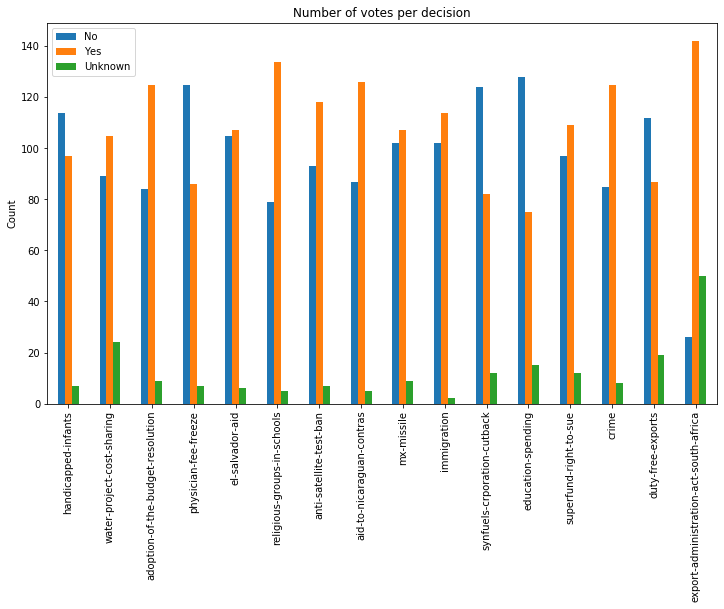

In [6]:
plot_count(training, "input_data_description")

In [7]:
training = clean_rows(training, 14)
training = imputate(training, False)
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.361905,0.461905,0.485714,0.585714,0.400000,0.500000,0.614286,0.552381,0.580952,0.490476,0.533333,0.385714,0.347619,0.509524,0.580952,0.414286,0.676190
std,0.481700,0.499738,0.500990,0.493775,0.491069,0.501195,0.487927,0.498437,0.494582,0.501104,0.500080,0.487927,0.477352,0.501104,0.494582,0.493775,0.469046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


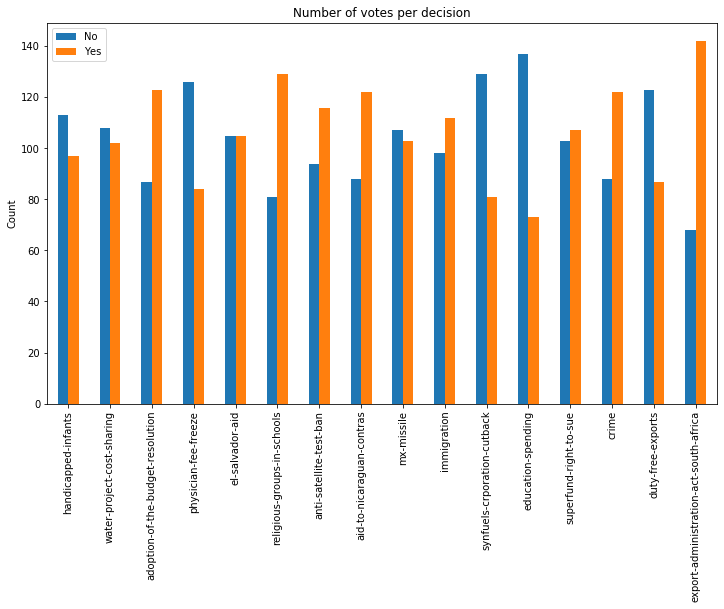

In [8]:
training_for_plot = training.copy()
plot_count(training, "data_after_cleaning_description")

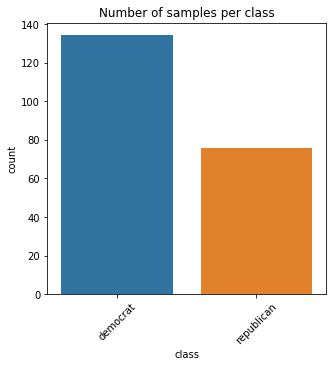

In [9]:
plot_result_classes(training, "classification_trainset")

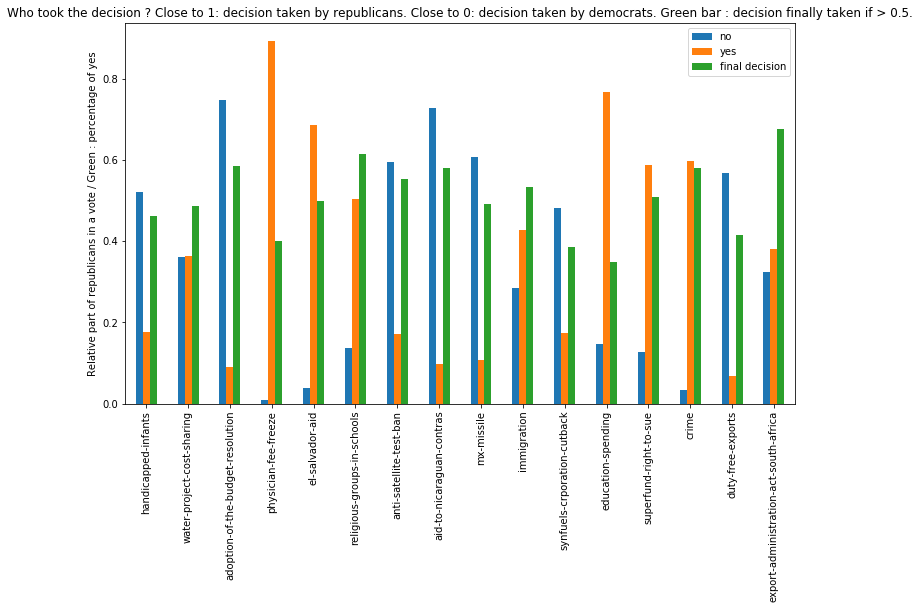

In [10]:
plot_decisions(training, False, "decisions_taken_trainset")

This bar chart shows two informations: first, the green bars permit to know what decision has been taken for each vote. If the green bar exceeds 0.5, the law has been adopted (the 'yes' triumphs).

Then, we have two bars. For each bar, it represents the percentage of republicans among all the people who voted "no" (for the blue bar) or "yes" (for the orange one). It is interesting because these two bars should stay barely the same for every datasets if the classification is well done.

# Training models : perceptron, random forest and naive Bayes

We decide to take cv=5 (number of folds) for the cross validation because our number of samples is small.

In [11]:
from sklearn.model_selection import train_test_split

# preprocessing with as parameters : 
#    thres : threshold for the number of minimum known values
#    imp : if true, uses the mmultivariate imputation, if not, fills missing values with random binary values
# outputs the training set, the target for the training, the test set and the target for the test set

def preprocessing(thres, imp) :
    training = transform_to_binary(training_init)
    training = clean_rows(training, thres)
    training = imputate(training, imp)
    
    train_target = training.drop('class', axis=1)
    train_set, test_set = train_test_split(training, test_size=0.2, random_state=42)
    train = np.array(train_set)[:,1:]
    train_target = np.array(train_set)[:,0]
    test = np.array(test_set)[:,1:]
    test_target = np.array(test_set)[:,0]
    
    return train, train_target, test, test_target

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
sns.set_style('whitegrid')

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a perceptron
# with the inputs as parameters

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=5)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a random forest
# with the inputs as parameters

def create_rnd_forest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=5)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a naive Bayes
# with the inputs as parameters

def create_nb(train_data, target, grid=[], **kwargs) :
    if grid != []:
        clf = GridSearchCV(MultinomialNB(), grid, refit = "f1_macro", verbose = 3,n_jobs=4, cv=5)
    else :
        clf =MultinomialNB(**kwargs)
    clf.fit(train_data , target)
    return clf

def most_frequent(List):
    counter = 0
    num = List[0]
      
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
  
    return num
    
# evaluates the algorithm by printing the relevant metrics and the confusion matrix for both train and test sets
# outputs the metrics as a dictionary
    
def evaluate_algo(algo, test_data, test_target, train_data, train_target):
    
    print(algo)
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)
    
    # outputs
    metrics_train = {"accuracy": 0, "balanced_accuracy": 0, "roc_auc": 0, "f1": 0, "precision": 0, "recall": 0}
    metrics_test = {"accuracy": 0, "balanced_accuracy": 0, "roc_auc": 0, "f1": 0, "precision": 0, "recall": 0}
    
    metrics_test["accuracy"] = accuracy_score(test_target, pred_test)
    metrics_test["balanced_accuracy"] = balanced_accuracy_score(test_target, pred_test)
    metrics_test["roc_auc"] = roc_auc_score(test_target, pred_test)
    metrics_test["f1"] = f1_score(test_target, pred_test)
    metrics_test["precision"] = precision_score(test_target, pred_test)
    metrics_test["recall"] = recall_score(test_target, pred_test)
    metrics_test["fbeta"] = fbeta_score(test_target, pred_test, 1)
    
    # report of metrics
    for score in metrics_train.keys():
        sc_train = cross_val_score(algo, train_data, train_target, cv=5, scoring=score).mean()
        print("cross validation " + score + " train : "+ str(sc_train))
        metrics_train[score] = sc_train
    
        print(score + " test : "+ str(metrics_test[score]))
    
    # plot of the confusion matrix
    # confusion matrix
    cmat = confusion_matrix(test_target, pred_test)
    cmat_train = confusion_matrix(train_target, pred_train)
    print("train : " + str(cmat_train[0]) + "   test :  " + str(cmat[0]) )
    print("        " + str(cmat_train[1]) + "           " + str(cmat[1]) )
    
    return metrics_test, metrics_train

# Perceptron

Test of different preprocessing methods with the optimal parameters found with grid search. We launch it 5 times to prevent a too large variation because of the random of the preprocessing. We have a range for thresholds of known values between 10 and 14 because we want to avoid having too less known values per sample (too large part for random values) or avoid the deletion of too much data because of the unknown values.

10
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
11
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
12
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
13
Fitting 5 folds for each of 

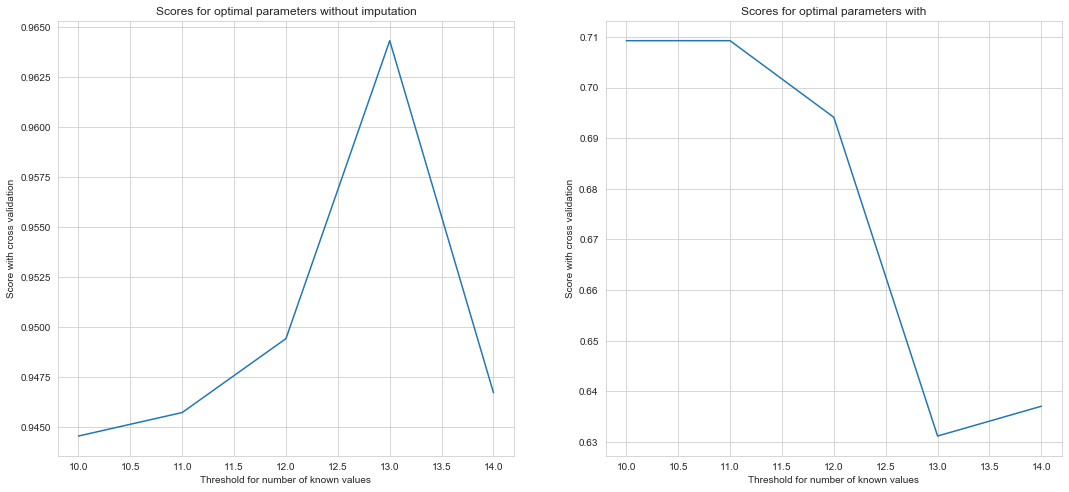

In [20]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {'eta0': [0.1,0.2,0.3,0.4],  
              'early_stopping': [True, False],
              'max_iter':[10,20,30,100],
              'tol':[1e-4,1e-3,1e-2,1e-1],
              'penalty':["l2","l1","elasticnet","None"]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True, False] :
    thresholds = np.arange(10,15)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        PPN = []
        PREPROS = []
        
        for i in range(5) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            PPN.append( create_perceptron(train, train_target, grid = param_grid) )
            score += PPN[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,PPN,PREPROS))
        scores.append(score/5)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_ppn" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We can see that the relevant imputation is the random imputation, and the optimal threshold is 13. 

Now with this preprocessing method, we evaluate the perceptron method optimized by grid search. Because of the random values, the optimize values can change from one run to another, that is why we repeated it 5 times and for the scores we always take the mean of the ten values for the 5 preprocessing configurations.

In [21]:
prepro_text = ""
best_ppn = None
datasets = []
score = 0
for (text, PPN, PREPROS) in L :
    new_score = 0
    for i in range(5) :
        prepro = PREPROS[i]
        ppn = PPN[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += ppn.best_score_
    new_score /= 5
    if new_score > score :
        score = new_score
        prepro_text = text
        best_ppn = PPN
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_ppn)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_ppn = best_ppn[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
ppn_grid = create_perceptron(train, train_target, **best_ppn.best_params_)
metrics_ppn = evaluate_algo(ppn_grid, test, test_target, train, train_target)

imputation: False, threshold = 13
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 20, 'penalty': 'elasticnet', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'None', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'None', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'None', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 20, 'penalty': 'elasticnet', 'tol': 0.01}


Perceptron(eta0=0.2, max_iter=10, penalty='None', tol=0.01)
cross validation accuracy train : 0.9645276292335115
accuracy test : 0.8837209302325582
cross validation balanced_accuracy train : 0.9613636363636363
balanced_accuracy test : 0.8564814814814814
cross validation roc_auc train : 0.9890151515151515
roc_auc test : 0.8564814814814815
cross validation f1 train : 0.9505574136008919
f1 test : 0.8275862068965517
cross validation precision train : 0.9547619047619047
precision test : 0.9230769230769231
cross valid

We have a big overfitting with grid search, so we have to optimize it manually. The problem is the imbalanced data, in order to increase the precision, we are creating a lot of false negatives.

To optimize manually, we use the validation set to compare and be aware if we are overfitting too much. We do not create a third dataset to do so because we do not have enough data, but we try to optimize the trainset accuracy on first instance in order to introduce a too big bias (and the test set is the one provided by Kaggle). We now run 10 times the preprocessing, because the operations are less costly so it takes a reasonable time.

First we optimize the threshold of the preprocessing (we consider directly a random imputation because we know that the other kind of imputations were not accurate at all).

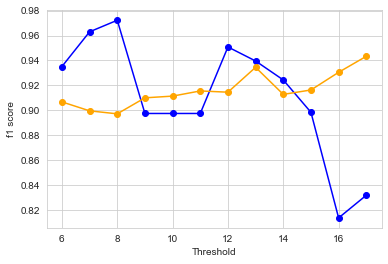

In [45]:
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = preprocessing(x, False)
        ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=20,tol=0.001, early_stopping=False, penalty=None)
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_ppn.pdf")

Best seems to be 13 as threshold, because with 6-8 as threshold we are too sensible to random values and with a threshold of 13 we have one of the best accuracy for trainset and no difference between accuracies of the two datasets. As we could have imagined, when we drop every sample with missing values, we have a strong overfitting, so a threshold of 15+ is not optimal.

Now we optimize the maximum number of iterations

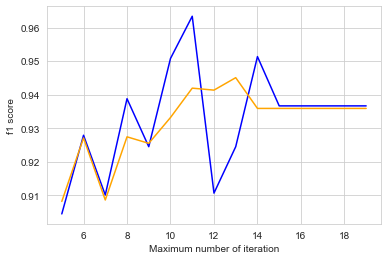

In [46]:
PREPROS_PPN = [preprocessing(13, imputation) for i in range(10)]

# maximum iterations
vals      = np.arange(5,20)
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=x,tol=0.001, early_stopping=False, penalty=None)
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Maximum number of iteration")
plt.ylabel("f1 score")
plt.savefig("./max_iter_ppn.pdf")

We choose 18 because the f1 score starts to be stable.

Now we choose the penalty parameter

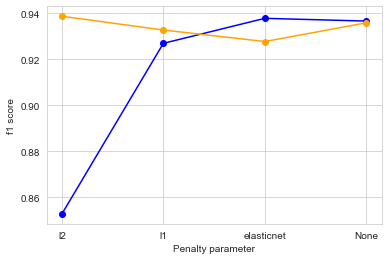

In [47]:
vals = ["l2","l1","elasticnet","None"]
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18, tol=0.001, early_stopping=False, penalty=x)
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Penalty parameter")
plt.ylabel("f1 score")
plt.savefig("./penalty_ppn.pdf")

It can change between runs but most of the time "None" is among the best choices.

Now we optimize the stopping criterion

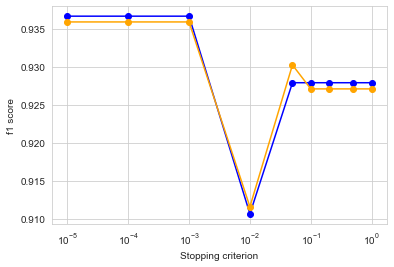

In [48]:
vals      = np.array([1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.2,0.5,1])
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=18,tol=x, early_stopping=False, penalty="None")
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")
plt.xlabel("Stopping criterion")
plt.ylabel("f1 score")
plt.savefig("./tol_ppn.pdf")

0.001 seems to be the best stopping criterion and have the best f1 score for the trainset.

Now we optimize the learning rate

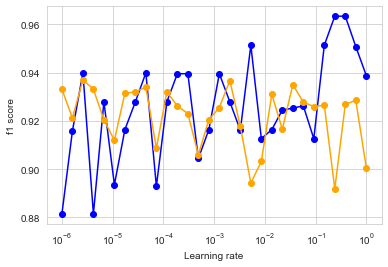

In [49]:
vals      = np.logspace(-6,0,num=30)
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        ppn = create_perceptron(train, train_target, eta0=x, max_iter=18,tol=0.001, early_stopping=False, penalty="None")
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")
plt.xlabel("Learning rate")
plt.ylabel("f1 score")
plt.savefig("./learning_rate_ppn.pdf")

A learning rate of 0.05 is great for both datasets.

Finally we choose if we want an early stopping

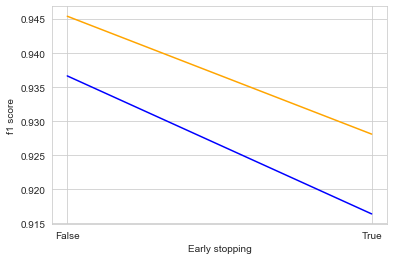

In [50]:
# early stopping
bools     = [False,True]
vals      = ["False","True"]
scores    = []
scores_cv = []
for x in bools :
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        ppn = create_perceptron(train, train_target, eta0=0.05, max_iter=18,tol=0.001, early_stopping=x, penalty="None")
        score += f1_score(test_target, ppn.predict(test), average="macro")
        score_cv += cross_val_score(ppn, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Early stopping")
plt.ylabel("f1 score")
plt.savefig("./early_stopping_ppn.pdf")

No early stopping is better for both datasets.

Now we create the perceptron that we got manually and we evaluate it :

In [58]:
best_ppn = None
score = 0
for i in range(10) :
    train, train_target, test, test_target = PREPROS_PPN[i]
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=0.001, early_stopping=False)
    new_score = f1_score(train_target, ppn.predict(train), average="macro")
    if new_score > score :
        score = new_score
        best_ppn = ppn
metrics_ppn = evaluate_algo(best_ppn, test, test_target, train, train_target)

Perceptron(eta0=0.1, max_iter=10)
cross validation accuracy train : 0.9347593582887701
accuracy test : 0.9534883720930233
cross validation balanced_accuracy train : 0.9308441558441558
balanced_accuracy test : 0.962962962962963
cross validation roc_auc train : 0.9934704184704184
roc_auc test : 0.962962962962963
cross validation f1 train : 0.910302016823756
f1 test : 0.9411764705882353
cross validation precision train : 0.9119047619047619
precision test : 0.8888888888888888
cross validation recall train : 0.9166666666666666
recall test : 1.0
train : [106   2]   test :  [25  2]
        [ 0 60]           [ 0 16]


So finally we have quite the same results as the perceptron that we had with the accuracy as scoring parameter. We have no overfitting and the f1 score of the train is better (not for the test though).

# Random forest

Test of different preprocessing methods with the optimal parameters found with grid search

10
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
11
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
12
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
13
Fitting 5 folds for each of 60 candidates, totalling 300 f

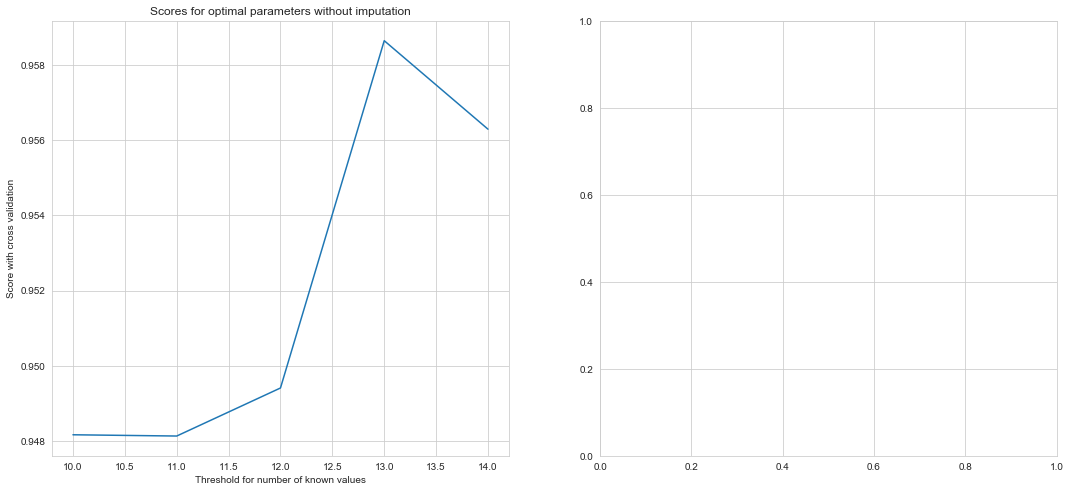

In [51]:
param_grid = {'criterion': ["gini", "entropy"],
              'n_estimators': [100],
              'min_samples_leaf': [0.01, 1, 2, 3, 4, 5],
              'ccp_alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
              #'min_samples_split': [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
             }  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

#for imputation in [True, False] :
for imputation in [False] :
    thresholds = np.arange(10,15)
    scores = []
    training = training_init.copy()
    for thres in thresholds :
        print(thres)
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        RNF = []
        PREPROS = []
        
        for i in range(5) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            RNF.append( create_rnd_forest(train, train_target, grid = param_grid) )
            score += RNF[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,RNF,PREPROS))
        scores.append(score/5)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_rdf" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We ran other test and the relevant imputation is the random imputation. Here we can see that the optimal threshold is 13

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [52]:
prepro_text = ""
best_rdf = None
datasets = []
score = 0
for (text, RDF, PREPROS) in L :
    new_score = 0
    for i in range(5) :
        prepro = PREPROS[i]
        rdf = RDF[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += rdf.best_score_
    new_score /= 5
    if new_score > score :
        score = new_score
        prepro_text = text
        best_rdf = RDF
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_rdf)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_rdf = best_rdf[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
rdf_grid = create_rnd_forest(train, train_target, **best_rdf.best_params_)
metrics_rdf = evaluate_algo(rdf_grid, test, test_target, train, train_target)

imputation: False, threshold = 13
{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100}
{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100}
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100}
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100}
{'ccp_alpha': 0.001, 'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100}


RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy')
cross validation accuracy train : 0.9349376114081996
accuracy test : 0.9534883720930233
cross validation balanced_accuracy train : 0.9393939393939392
balanced_accuracy test : 0.9502314814814814
cross validation roc_auc train : 0.9905303030303031
roc_auc test : 0.9502314814814816
cross validation f1 train : 0.9213416149068323
f1 test : 0.9375
cross validation precision train : 0.9192307692307693
precision test : 0.9375
cross validation recall train : 0.95
r

We can see that with the grid search we have again a slight overfitting, so we have to optimize it manually. We use the test set to compare and be aware if we are overfitting too much. We have also here a problem of precision.

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

6
7
8
9
10
11
12
13
14
15
16
17


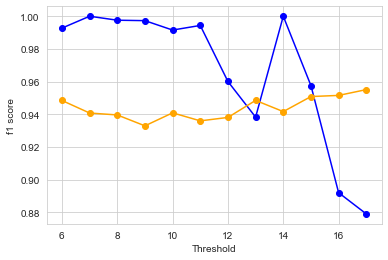

In [53]:
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = preprocessing(x, False)
        rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=200)
        score += f1_score(test_target, rdf.predict(test), average="macro")
        score_cv += cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_rdf.pdf")

We choose 13 because it is one of the best accuracy for trainset and we are not overfitting. What is more, we want to maintain the more data we can.

Now we choose the right criterion between Gini and entropy

gini
entropy


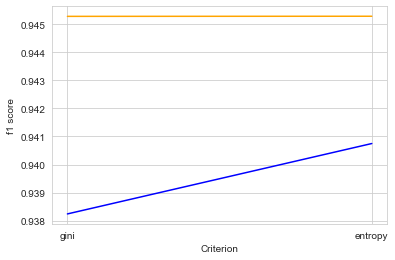

In [76]:
PREPROS_RDF = [preprocessing(13, imputation) for i in range(10)]

vals      = ["gini", "entropy"]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        rdf = create_rnd_forest(train, train_target, criterion=x, n_estimators=200)
        score += f1_score(test_target, rdf.predict(test), average="macro")
        score_cv += cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Criterion")
plt.ylabel("f1 score")
plt.savefig("./criterion_rdf.pdf")

We can choose entropy or Giny without a real difference

Now we optimize the minimum number of samples on a leaf (0.01 is a fraction)

0.01
1
2
3
4
5


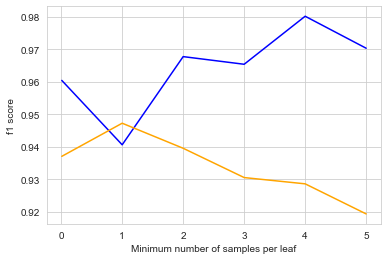

In [77]:
# min_samples_leaf
vals      = [0.01, 1, 2, 3, 4, 5]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=x)
        score += f1_score(test_target, rdf.predict(test), average="macro")
        score_cv += cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Minimum number of samples per leaf")
plt.ylabel("f1 score")
plt.savefig("./min_samples_leaf_rdf.pdf")

The best choice is 1, to have the best accuracy on train set and no overfitting

Now we optimize the complexity parameter used for Minimal Cost-Complexity Pruning

0.0001
0.001
0.01
0.1
1


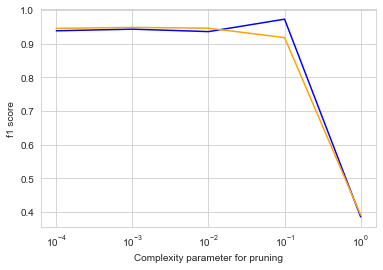

In [78]:
# ccp_alpha 
vals      = [1e-4, 1e-3, 1e-2, 1e-1, 1]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=1, ccp_alpha=x)
        score += f1_score(test_target, rdf.predict(test), average="macro")
        score_cv += cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")
plt.xlabel("Complexity parameter for pruning")
plt.ylabel("f1 score")
plt.savefig("./ccp_alpha_rdf.pdf")

We take cpp_alpha = 0.001 because it's the optimum for the trainset and it is relatively stable

Finally we optimize the mimum samples to split a node

0.01
0.04
0.07
0.1
0.15
0.2
0.3
0.5


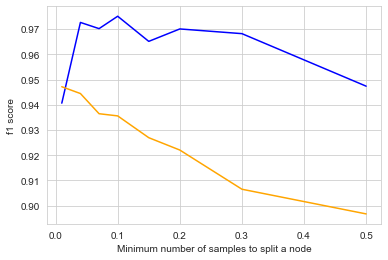

In [79]:
# min_samples_split
vals      = [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_PPN[i]
        rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=1, ccp_alpha=0.001, min_samples_split=x)
        score += f1_score(test_target, rdf.predict(test), average="macro")
        score_cv += cross_val_score(rdf, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")
plt.xlabel("Minimum number of samples to split a node")
plt.ylabel("f1 score")
plt.savefig("./min_samples_split_rdf.pdf")

0.04 seems to be the best choice.

Now we create the random forest that we got manually and we evaluate it :

In [90]:
best_rdf = None
score = 0
for i in range(10) :
    train, train_target, test, test_target = PREPROS_RDF[i]
    rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=1, ccp_alpha=0.001, min_samples_split=0.04)
    new_score = f1_score(train_target, rdf.predict(train), average="macro")
    if new_score > score :
        score = new_score
        best_rdf = rdf
metrics_rdf = evaluate_algo(best_rdf, test, test_target, train, train_target)

RandomForestClassifier(ccp_alpha=0.001, criterion='entropy',
                       min_samples_split=0.04, n_estimators=200)
cross validation accuracy train : 0.9351158645276293
accuracy test : 0.9767441860465116
cross validation balanced_accuracy train : 0.9431818181818181
balanced_accuracy test : 0.9814814814814814
cross validation roc_auc train : 0.9893578643578642
roc_auc test : 0.9814814814814815
cross validation f1 train : 0.9232680363115146
f1 test : 0.9696969696969697
cross validation precision train : 0.9038095238095238
precision test : 0.9411764705882353
cross validation recall train : 0.9333333333333333
recall test : 1.0
train : [106   2]   test :  [26  1]
        [ 1 59]           [ 0 16]


So finally we have a random forest which performs very well but maybe we introduced too much bias with the test set. 
We finally got the same parameters (with in addition the optimization of the minimum number of samples to split a node) but here we have a better f1 score.

# Naive Bayes

Test of different preprocessing methods with the optimal parameters found with grid search

10
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
11
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
12
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
13
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 

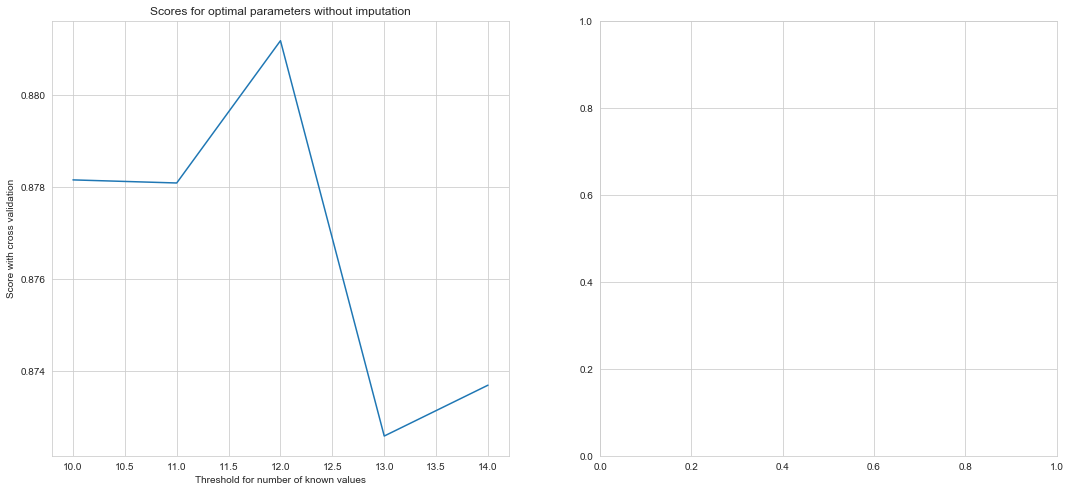

In [60]:
# test of different preprocessing methods with the optimal parameters 

import warnings
warnings.filterwarnings('ignore')

param_grid = {'alpha': [1e-2, 1e-1, 0.5, 1, 10, 100]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

#for imputation in [True, False] :
for imputation in [False] :
    thresholds = np.arange(10,15)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        NB = []
        PREPROS = []
        
        for i in range(5) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            NB.append( create_nb(train, train_target, grid = param_grid) )
            score += NB[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,NB,PREPROS))
        scores.append(score/5)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")
    extent = fig.get_window_extent().transformed(fig.figure.dpi_scale_trans.inverted())
    fig.figure.savefig("./threshold_grid_nb" + str(int(imputation)) + ".pdf", bbox_inches=extent.expanded(1.2, 1.2))

We can see that the relevant imputation is the random imputation, and the optimal threshold is 16.

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [61]:
prepro_text = ""
best_nb = None
datasets = []
score = 0
for (text, NB, PREPROS) in L :
    new_score = 0
    for i in range(5) :
        prepro = PREPROS[i]
        nb = NB[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += nb.best_score_
    new_score /= 5
    if new_score > score :
        score = new_score
        prepro_text = text
        best_nb = NB
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_nb)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_nb = best_nb[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
nb_grid = create_nb(train, train_target, **best_nb.best_params_)
metrics_nb = evaluate_algo(nb_grid, test, test_target, train, train_target)

imputation: False, threshold = 12
{'alpha': 0.01}
{'alpha': 0.01}
{'alpha': 0.01}
{'alpha': 0.01}
{'alpha': 0.01}


MultinomialNB(alpha=0.01)
cross validation accuracy train : 0.8764705882352942
accuracy test : 0.8604651162790697
cross validation balanced_accuracy train : 0.8803696303696302
balanced_accuracy test : 0.8634259259259259
cross validation roc_auc train : 0.9611804861804861
roc_auc test : 0.8634259259259259
cross validation f1 train : 0.8419519739519739
f1 test : 0.823529411764706
cross validation precision train : 0.8059615384615384
precision test : 0.7777777777777778
cross validation recall train : 0.8897435897435896
recall test : 0.875
train : [95 13]   test :  [23  4]
        [ 5 57]           [ 2 14]


We can see that, even if we don't have any overfitting, the algorithm has not a very great accuracy. Here the problem is once again the precision. We use the test set to compare and be aware if we are overfitting too much. 

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

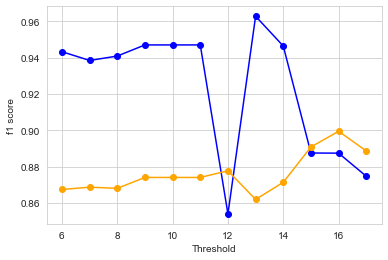

In [62]:
# threshold for preprocessing
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = preprocessing(x, False)
        nb = create_nb(train, train_target)
        score += f1_score(test_target, nb.predict(test), average="macro")
        score_cv += cross_val_score(nb, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
plt.savefig("./thresholds_nb.pdf")

We choose 15 because it is the best accuracy for trainset and we are not overfitting too much.

Now we optimize the Laplace smoothing parameter

0.01
0.012663801734674034
0.0160371874375133
0.020309176209047358
0.025719138090593445
0.03257020655659783
0.04124626382901352
0.052233450742668434
0.06614740641230149
0.08376776400682916
0.10608183551394483
0.13433993325989002
0.17012542798525893
0.21544346900318834
0.2728333376486768
0.34551072945922184
0.43754793750741844
0.5541020330009492
0.7017038286703826
0.8886238162743403
1.1253355826007645
1.4251026703029979
1.8047217668271702
2.2854638641349907
2.8942661247167516
3.665241237079626
4.6415888336127775
5.878016072274912
7.443803013251689
9.426684551178854
11.937766417144358
15.117750706156615
19.144819761699576
24.244620170823282
30.702906297578497
38.88155180308085
49.238826317067364
62.355073412739124
78.96522868499724
100.0


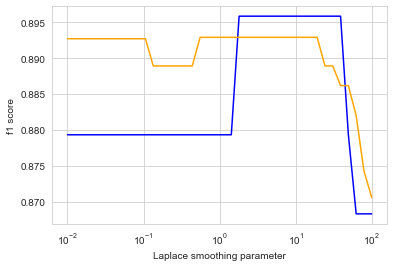

In [63]:
PREPROS_NB = [preprocessing(15, imputation) for i in range(10)]

vals      = np.logspace(-2, 2, 40)
scores    = []
scores_cv = []
for x in vals:
    print(x)
    score = 0
    score_cv = 0
    for i in range(10) :
        train, train_target, test, test_target = PREPROS_NB[i]
        nb = create_nb(train, train_target, alpha=x)
        score += f1_score(test_target, nb.predict(test), average="macro")
        score_cv += cross_val_score(nb, train, train_target,scoring="f1_macro", cv=5).mean()
    scores.append(score/10)
    scores_cv.append(score_cv/10)
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")
plt.xlabel("Laplace smoothing parameter")
plt.ylabel("f1 score")
plt.savefig("./laplace_nb.pdf")

10 is the best choice (best accuracy for both train set and test set).

Now we create the multinomial naive Bayes that we got manually and we evaluate it :

In [64]:
best_nb = None
score = 0
for i in range(10) :
    train, train_target, test, test_target = PREPROS_NB[i]
    nb = create_nb(train, train_target, alpha=10)
    new_score = f1_score(train_target, nb.predict(train), average="macro")
    if new_score > score :
        score = new_score
        best_nb = nb
metrics_nb = evaluate_algo(best_nb, test, test_target, train, train_target)

MultinomialNB(alpha=10)
cross validation accuracy train : 0.9
accuracy test : 0.9
cross validation balanced_accuracy train : 0.9066233766233767
balanced_accuracy test : 0.9230769230769231
cross validation roc_auc train : 0.9648376623376624
roc_auc test : 0.9230769230769231
cross validation f1 train : 0.8746303551520942
f1 test : 0.8750000000000001
cross validation precision train : 0.8302197802197803
precision test : 0.7777777777777778
cross validation recall train : 0.9318181818181819
recall test : 1.0
train : [89 12]   test :  [22  4]
        [ 3 56]           [ 0 14]


So finally we have a naive Bayes which is not as performant as random forest but which has no over or underfitting. Here also we have a problem of precision. With more samples it would have been better to create a third set which is totally independant and test it again on this validation set.

# Results on Kaggle test set

Preprocessing of testset

In [91]:
imputation = False
test = pd.read_csv("./CongressionalVotingID.shuf.tes.csv")
test_init = test.copy()
test.drop('ID', axis=1, inplace=True)
test = test.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
m = test.copy()
n = m.isna().sum(axis=1)
n.name = "missing values in row"
d = n.to_frame()
d["number of rows"] = test_init["ID"]
d = d.groupby("missing values in row").count()
if (imputation) :
    array = np.round(imp.transform(test))
    test = pd.DataFrame(array, columns = test.columns)
else :
    test = test.fillna(random.randint(0,1))
test.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,0.437788,0.525346,0.599078,0.437788,0.525346,0.663594,0.589862,0.580645,0.520737,0.493088,0.354839,0.516129,0.520737,0.608295,0.442396,0.834101
std,0.497262,0.500512,0.491218,0.497262,0.500512,0.473572,0.492996,0.494594,0.500725,0.501108,0.479571,0.500895,0.500725,0.489260,0.497819,0.372850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Results on testset, using our best algorithm in term of accuracy and with the best parameters (we can notice that, except for the perceptron, when we optimize manually with another threshold, we obtain quite different parameters) :

Perceptron(eta0=0.2, max_iter=10, penalty='None', tol=0.01)
0.9283971471471469
Perceptron(eta0=0.1, max_iter=10)
0.9511298421807751
RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy')
0.9703804347826088
RandomForestClassifier(ccp_alpha=0.001, criterion='entropy',
                       min_samples_split=0.04, n_estimators=200)
0.9655335968379447
MultinomialNB(alpha=0.01)
0.8893523115966016
MultinomialNB(alpha=10)
0.8897997758192486


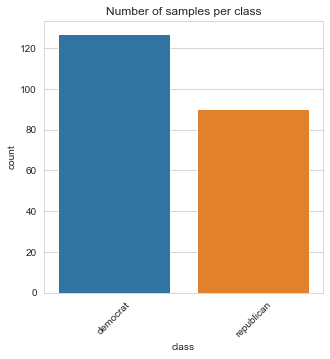

In [92]:
algo = None
best_score = 0

t = training_init.copy()
t.drop('ID', axis=1, inplace=True)
t = t.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
t = t.fillna(random.randint(0,1))
y = t['class']
t.drop('class', axis=1, inplace=True)

for alg in [ppn_grid, best_ppn, rdf_grid, best_rdf, nb_grid, best_nb] :
    score = 0
    for i in range(20) :
        predict = alg.predict(t)
        score += f1_score(y, predict, average="macro")
    score /= 20
    print(alg)
    print(score)
    if score > best_score :
        algo = alg
        best_score = score

classification = algo.predict(test)
result = test.copy()
result["class"] = classification
plot_result_classes(result, "Classification on testset")

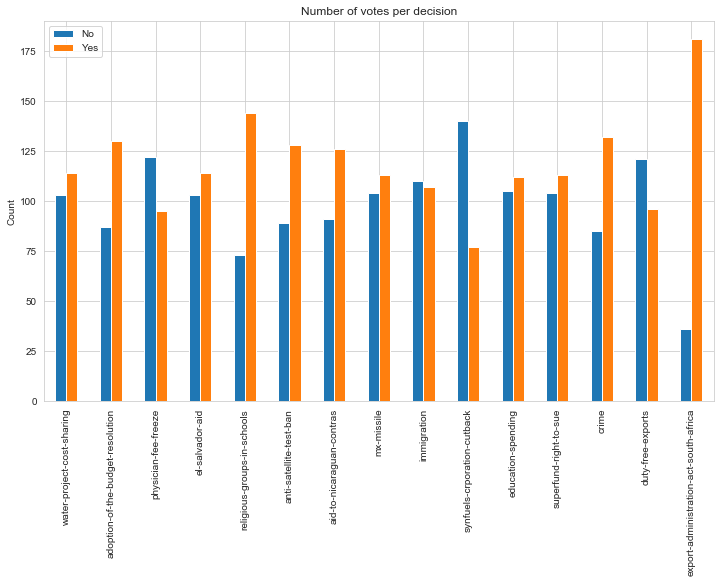

In [93]:
plot_count(test, "Count test")

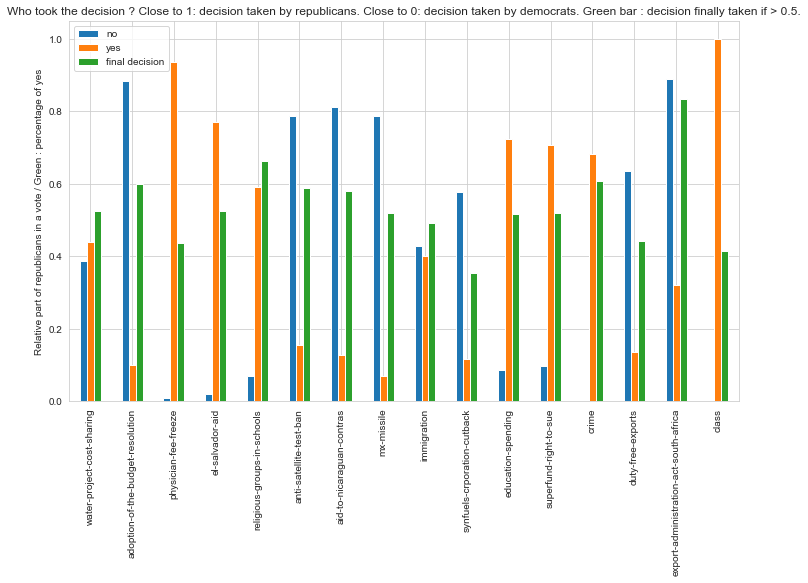

In [94]:
plot_decisions(result, False, "Decisions test")

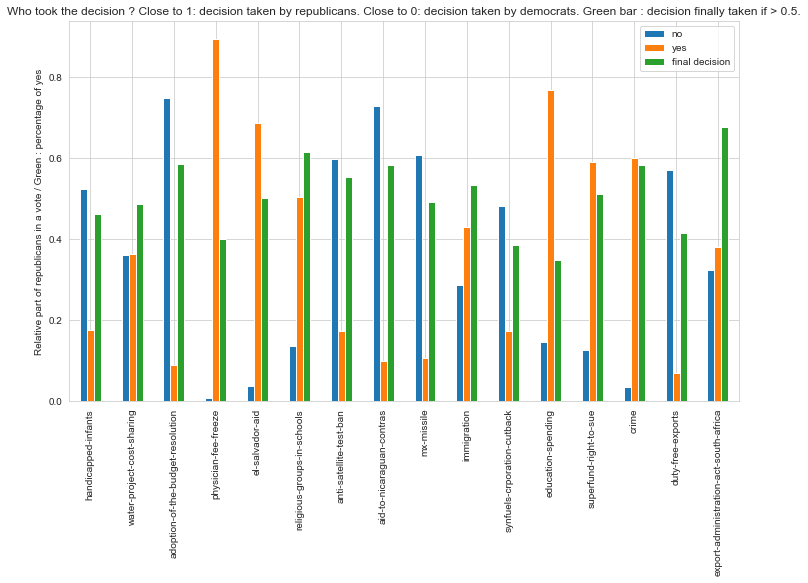

In [95]:
# compare with training
plot_decisions(training_for_plot, False, "Compare to train")

What we can say about these two lasts figures is that it seems really accurate, with a very similar repartition of republican voters for every response on each vote between the training dataset and the testset.

# Creation of Kaggle submission

In [96]:
def create_csv(number, predict) :
    res = pd.DataFrame(test_init["ID"], columns = ["ID"])
    final_predict = []
    for binary in predict :
        if binary > 0.5 :
            final_predict.append("republican")
        else :
            final_predict.append("democrat")
    res["class"] = final_predict
    path = "./try" + str(number) + ".csv"
    res.to_csv(path, index=False)

We create a csv file for the three algorithms, with grid search or manually seach each time.

In [97]:
# First tries

    #1 manually optimized random forest without average on 10 preprocessing

    #2 grid search on perceptron without average on 10 preprocessing

    #3 grid search on perceptron

#4 grid search on perceptron
#create_csv(4, ppn_grid.predict(test))

#5 manually search on perceptron
#create_csv(5, best_ppn.predict(test))

#6 grid search with random forest
#create_csv(6, rdf_grid.predict(test))

#7 manually search with random forest
#create_csv(7, best_rdf.predict(test))

#8 grid search on naive Bayes
#create_csv(8, nb_grid.predict(test))

#9 manually search on naive Bayes
#create_csv(9, best_nb.predict(test))

#10 grid search on perceptron with f1 as optimized parameter
create_csv(10, ppn_grid.predict(test))

#11 manually search on perceptron with f1 as optimized parameter
create_csv(11, best_ppn.predict(test))

#12 grid search with random forest with f1 as optimized parameter
create_csv(12, rdf_grid.predict(test))

#13 manually search with random forest with f1 as optimized parameter
create_csv(13, best_rdf.predict(test))

#the Naive Bayes algorithms are not relevant

# Possible improvements

It would have been possible to make another grid search with a smaller threshold and test it again on kaggle, with maybe a different function for scoring: we were using only balanced accuracy, but for every algorithm we had had a problem for precision, so we could have tested a mix between balanced accuracy and precision.